In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=31.5s


In [4]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load other data 

In [5]:
dic_data_raw = {}
dic_data_processed = {}

# Aizarani et al. Liver atlas
dic_data_raw['aizarani'] = dl.load_aizarani_raw_data(opt='raw')
dic_data_processed['aizarani'] = dl.load_aizarani_raw_data(opt='processed')

DNAME_LIST = ['aizarani']

### Load gene annotation

In [6]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

In [7]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


### Compute TRS

In [8]:
# Precompute statistics 
md.compute_stats(data_facs_ct)

In [12]:
# Tissue and tissue-cell type list
TISSUE_LIST = list(set(data_facs_ct.obs['tissue']))
TISSUE_LIST.sort()
TC_LIST = list(set(data_facs_ct.obs['tissue_celltype']))
TC_LIST.sort()
print('# facs data: n_tissue=%d n_tissue_celltype=%d'%(len(TISSUE_LIST), len(TC_LIST)))

# Get GWAS trait geneset
TRAIT_LIST = ['PASS_Alzheimers_Jansen2019', 'PASS_HDL', 'PASS_FastingGlucose_Manning', 'PASS_IBD_deLange2017']

dic_tgs = {}
for trait in TRAIT_LIST:
    # Find FDR<0.1 genes 
    temp_df = df_geneannot[[trait]].copy()
    temp_df.columns = ['z_score']
    temp_df['p_val'] = 1 - sp.stats.norm.cdf(temp_df['z_score'].values)
    temp_df['fdr'] = multipletests(temp_df['p_val'].values, method='fdr_bh')[1]
    dic_tgs[trait] = list(temp_df.index[temp_df['fdr']<0.1])
    
# Random gene set
for i_rep in range(2):
    dic_tgs['Random%d'%i_rep] = list(np.random.choice(data_facs_ct.var_names, size=500))
    TRAIT_LIST.append('Random%d'%i_rep)
    
for trait in TRAIT_LIST:
    print('# %-40s n_gene=%d'%(trait, len(dic_tgs[trait])))

# facs data: n_tissue=23 n_tissue_celltype=207
# PASS_Alzheimers_Jansen2019               n_gene=298
# PASS_HDL                                 n_gene=527
# PASS_FastingGlucose_Manning              n_gene=167
# PASS_IBD_deLange2017                     n_gene=1703
# Random0                                  n_gene=500
# Random1                                  n_gene=500


In [13]:
# Obtain TRS
dic_trs = {}
start_time = time.time()
for trait in TRAIT_LIST:
    
    # mean, n_genes
    md.score_cell(data_facs_ct, dic_tgs[trait], suffix='',
                  ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                  n_ctrl=10, n_genebin=200, cov_list=['mean', 'n_genes'],
                  return_list=['trs', 'trs_z', 'trs_ep', 'trs_ez'], verbose=False)
    
    dic_trs['%s;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
    dic_trs['%s;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
    dic_trs['%s;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
    dic_trs['%s;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()
    
    # mean, n_genes
    md.score_cell(data_facs_ct, dic_tgs[trait], suffix='',
                  ctrl_opt='mean_match', trs_opt='vst', bc_opt='debug',
                  n_ctrl=100, n_genebin=200, cov_list=None,
                  return_list=['trs', 'trs_z', 'trs_ep', 'trs_ez'], verbose=False)
    
    dic_trs['%s;new_trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
    dic_trs['%s;new_trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
    dic_trs['%s;new_trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
    dic_trs['%s;new_trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()
    
    print('#%-40s time=%0.1fs'%(trait,time.time()-start_time))

#PASS_Alzheimers_Jansen2019               time=110.9s
#PASS_HDL                                 time=227.0s
#PASS_FastingGlucose_Manning              time=327.8s
#PASS_IBD_deLange2017                     time=475.8s
#Random0                                  time=590.0s
#Random1                                  time=703.9s


In [19]:
# Number of rejections 
for config in ['trs_ep', 'new_trs_ep']:
    for trait in TRAIT_LIST:
        v_p = dic_trs['%s;%s'%(trait, config)]
        v_fdr = multipletests(v_p, method='fdr_bh')[1]
        print('# %s %-30s n_rej=%d'%(config, trait, (v_fdr<0.05).sum()))

        temp_df = data_facs_ct.obs.loc[(v_fdr<0.05)].groupby(by=['tissue_celltype']).agg({'cell':len})
        if (temp_df['cell']>5).sum()>0:
            print(temp_df.loc[temp_df['cell']>10])
            print('')
    print('')

# trs_ep PASS_Alzheimers_Jansen2019     n_rej=0
# trs_ep PASS_HDL                       n_rej=0
# trs_ep PASS_FastingGlucose_Manning    n_rej=0
# trs_ep PASS_IBD_deLange2017           n_rej=0
# trs_ep Random0                        n_rej=0
# trs_ep Random1                        n_rej=0

# new_trs_ep PASS_Alzheimers_Jansen2019     n_rej=1
# new_trs_ep PASS_HDL                       n_rej=49
                             cell
tissue_celltype                  
Pancreas.pancreatic PP cell    21

# new_trs_ep PASS_FastingGlucose_Manning    n_rej=755
                            cell
tissue_celltype                 
Pancreas.pancreatic B cell   729

# new_trs_ep PASS_IBD_deLange2017           n_rej=1357
                                                    cell
tissue_celltype                                         
BAT.myeloid cell                                      12
GAT.CD4-positive, alpha-beta T cell                   51
GAT.CD8-positive, alpha-beta T cell                   18
GAT.T cel

### Covariates 

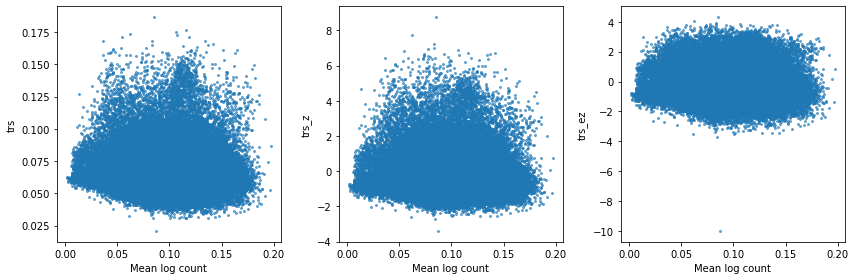

In [26]:
trait='PASS_HDL'
plt.figure(figsize=[12,4])
for i_config,config in enumerate(['trs', 'trs_z', 'trs_ez']):
    plt.subplot(1,3,i_config+1)
    plt.scatter(data_facs_ct.obs['mean'], dic_trs['%s;%s'%(trait, config)], s=4, alpha=0.6)
    plt.ylabel(config)
#     plt.ylim([-4,4])
    plt.xlabel('Mean log count')
plt.tight_layout()
plt.show()

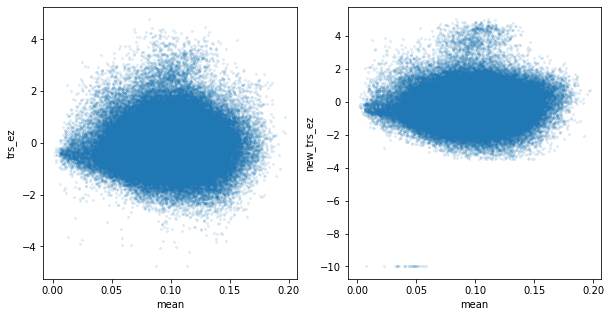

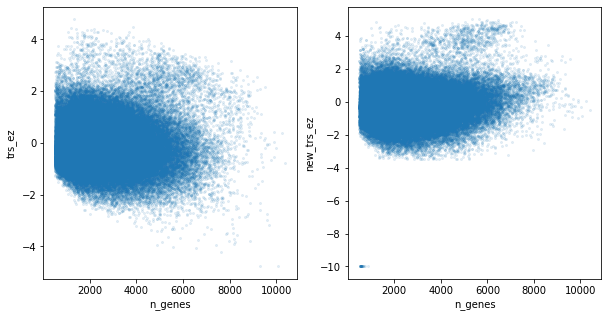

In [104]:
trait='PASS_FastingGlucose_Manning'
for covariate in ['mean', 'n_genes']:
    plt.figure(figsize=[10,5])
    for i_config,config in enumerate(['trs_ez', 'new_trs_ez']):
        plt.subplot(1,2,i_config+1)
        plt.scatter(data_facs_ct.obs[covariate], dic_trs['%s;%s'%(trait, config)], s=4, alpha=0.1)
        plt.ylabel(config)
        plt.xlabel(covariate)
    plt.tight_layout
    plt.show()

### Per-tissue TRS distribution 

all trs_ez


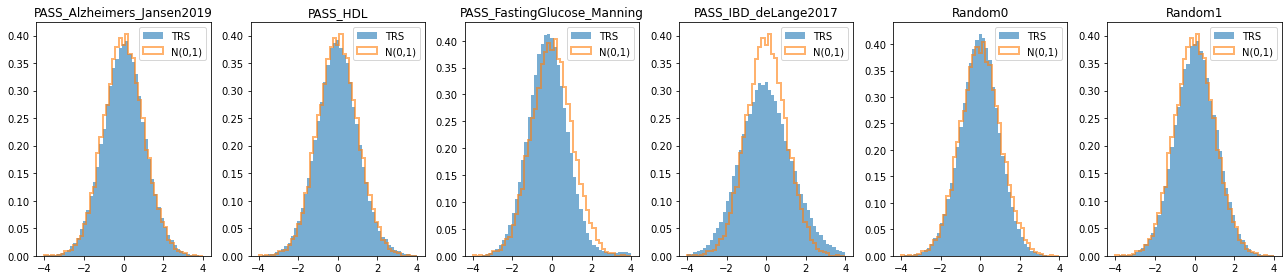

all new_trs_ez


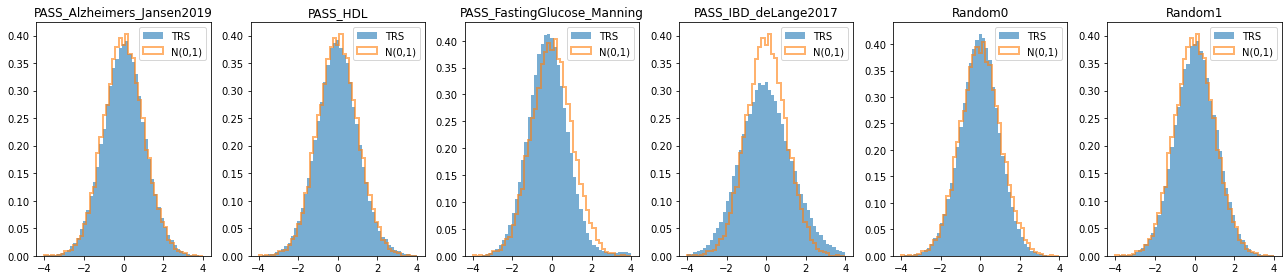

Liver trs_ez


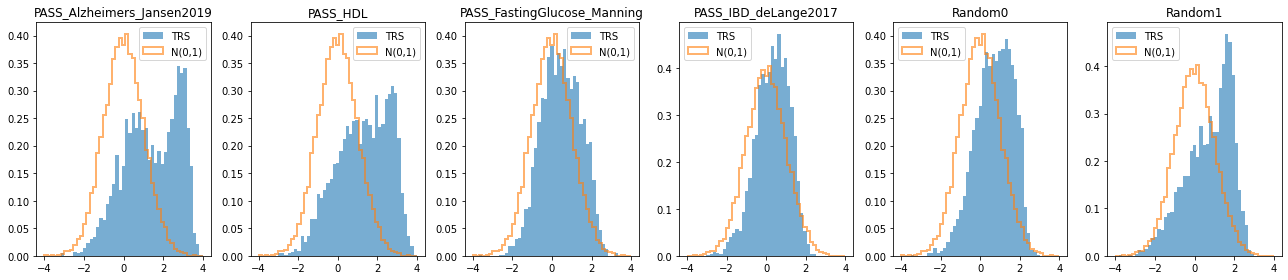

Liver new_trs_ez


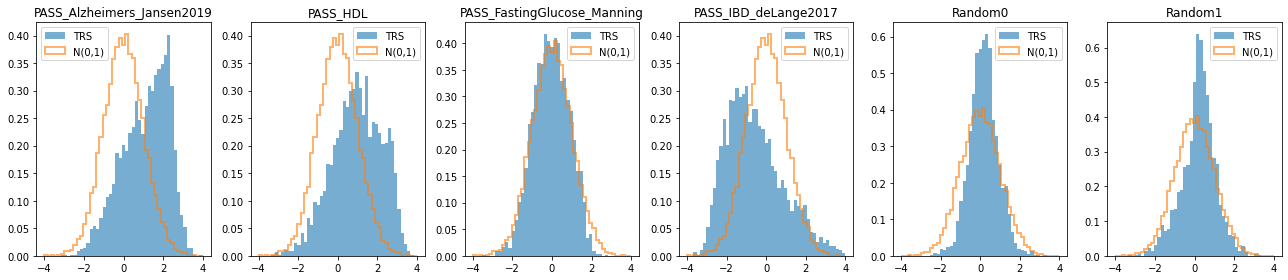

Marrow trs_ez


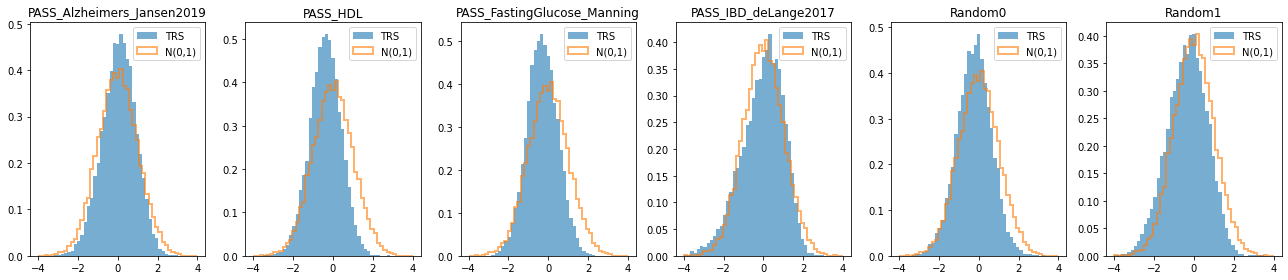

Marrow new_trs_ez


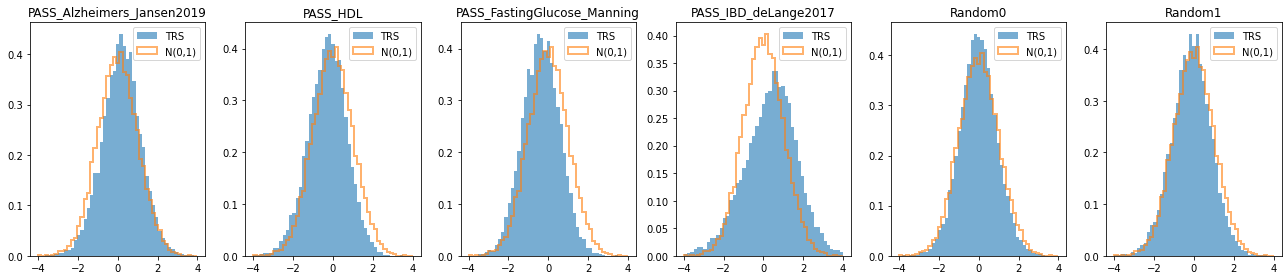

In [39]:
bins_ = np.linspace(-4,4,50)
v_norm = np.random.randn(10000)

for i_tissue,tissue in enumerate(['all']+['Liver', 'Marrow']):
    for config in ['trs_ez', 'new_trs_ez']:
        print(tissue, config)
        plt.figure(figsize=[18,4])
        
        for i_trait,trait in enumerate(TRAIT_LIST):
            
                plt.subplot(1,6,i_trait+1)
                if tissue=='all':
                    v_trs = dic_trs['%s;new_trs_ez'%(trait)]
                else:
                    ind_select = data_facs_ct.obs['tissue']==tissue
                    v_trs = dic_trs['%s;%s'%(trait, config)][ind_select]
                plt.hist(v_trs, alpha=0.6, bins=bins_, density='True', label='TRS')
                plt.hist(v_norm, alpha=0.6, bins=bins_, density='True', histtype='step', linewidth=2, label='N(0,1)')
                plt.legend()
                plt.title(trait)

        plt.tight_layout()
        plt.show()

### Heterogeneity pattern

Liver trs_ez


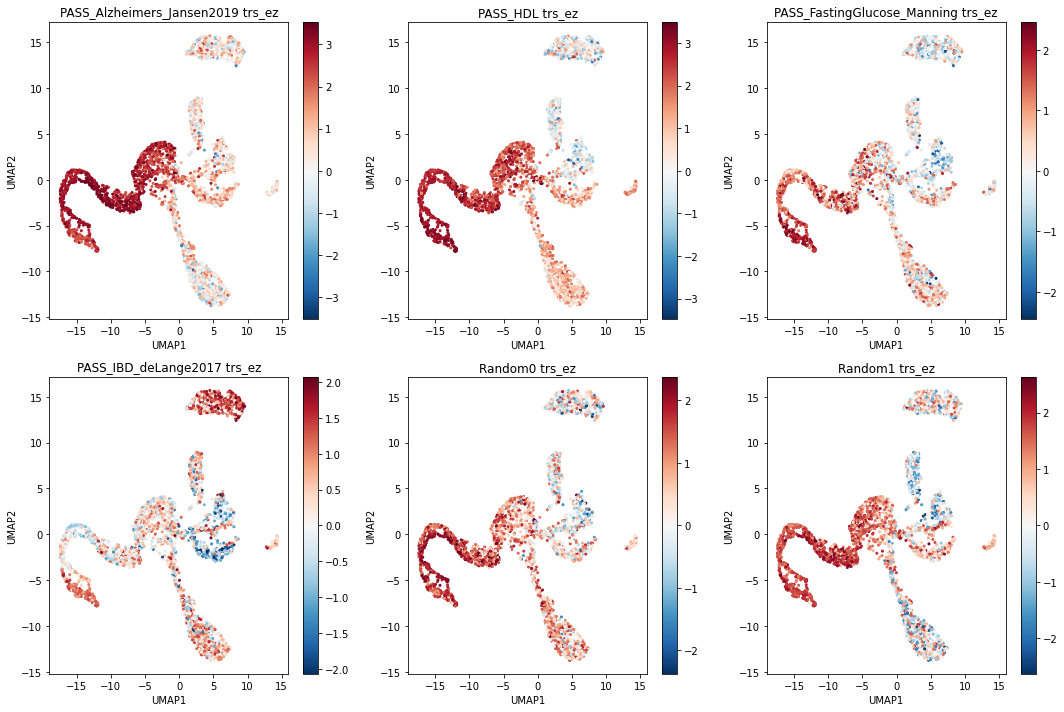

Liver new_trs_ez


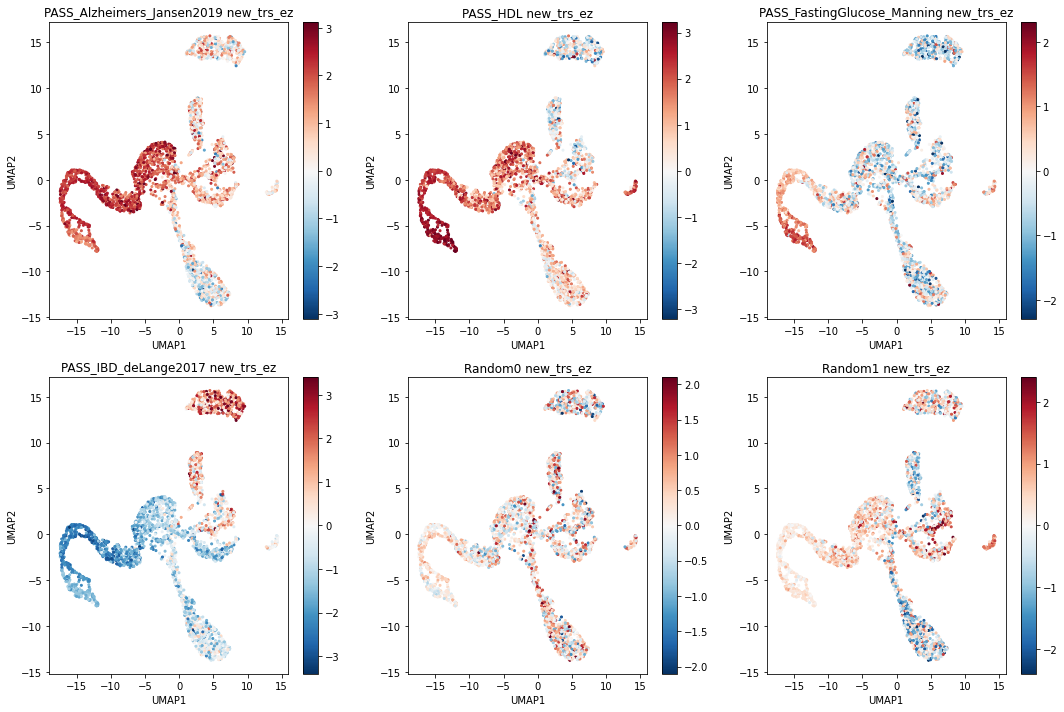

BAT trs_ez


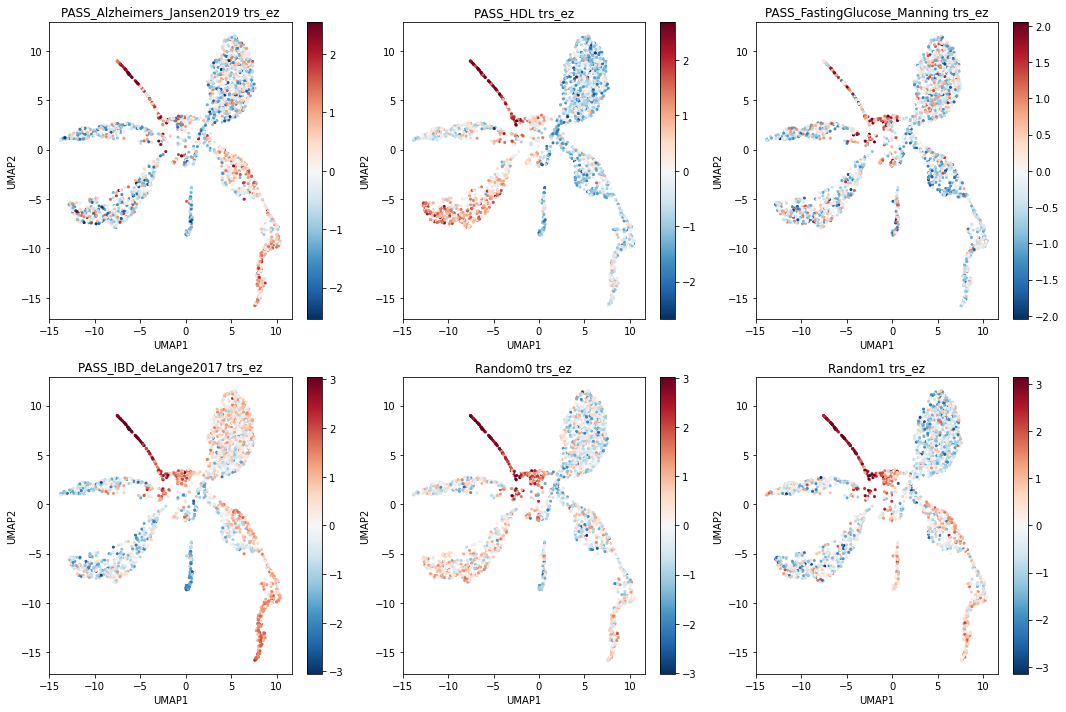

BAT new_trs_ez


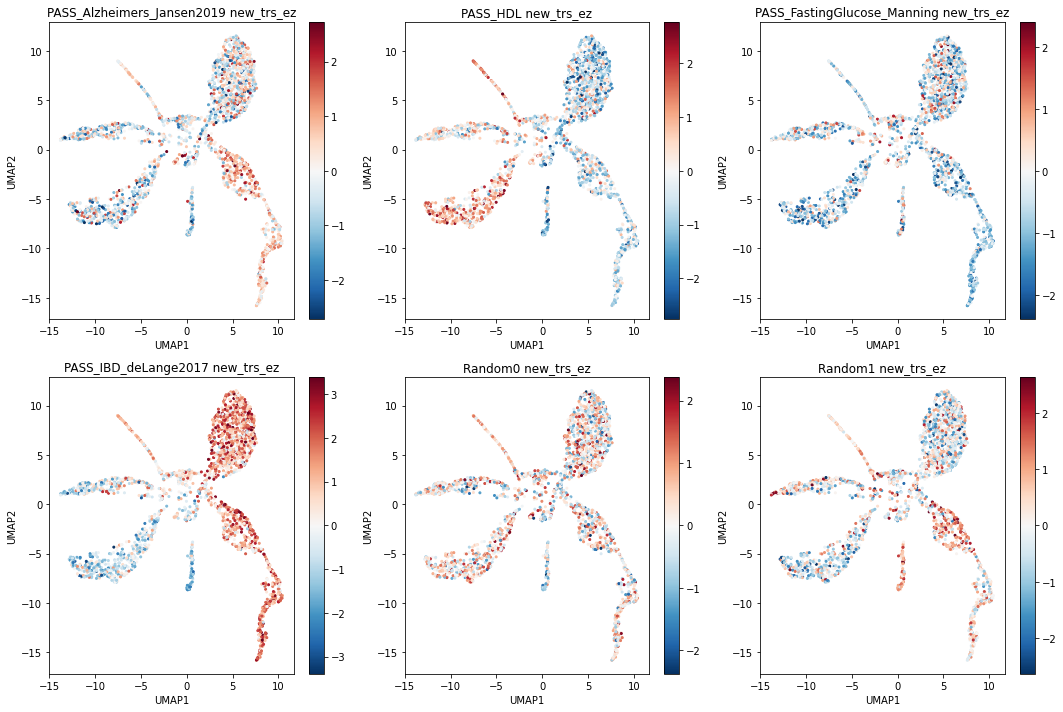

Marrow trs_ez


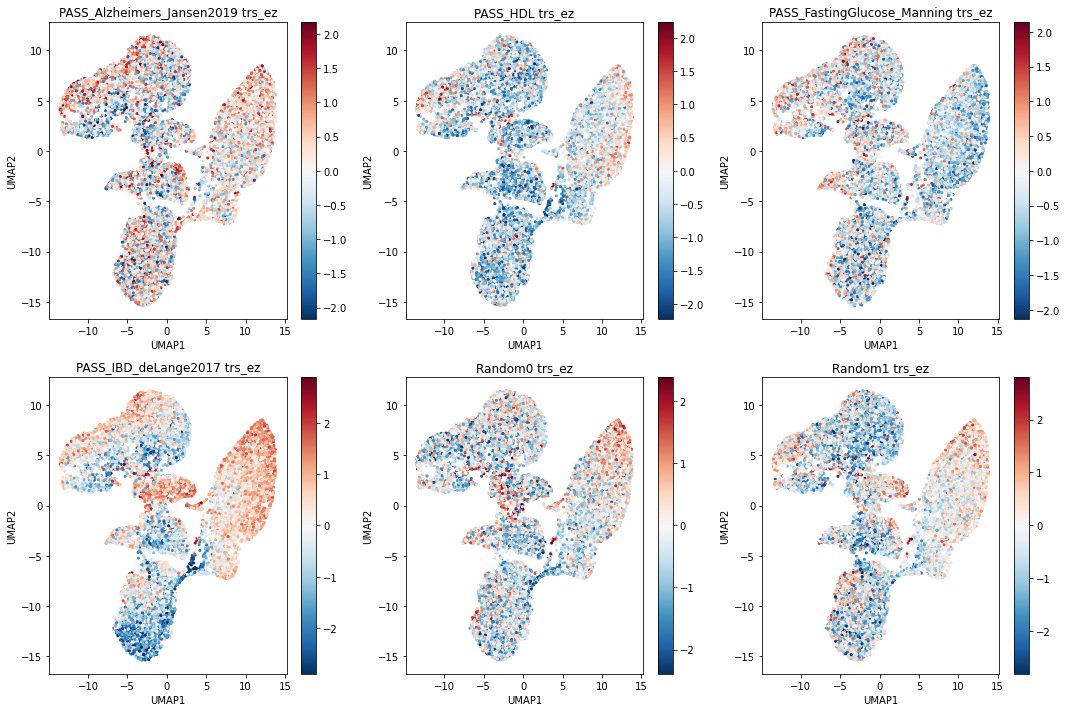

Marrow new_trs_ez


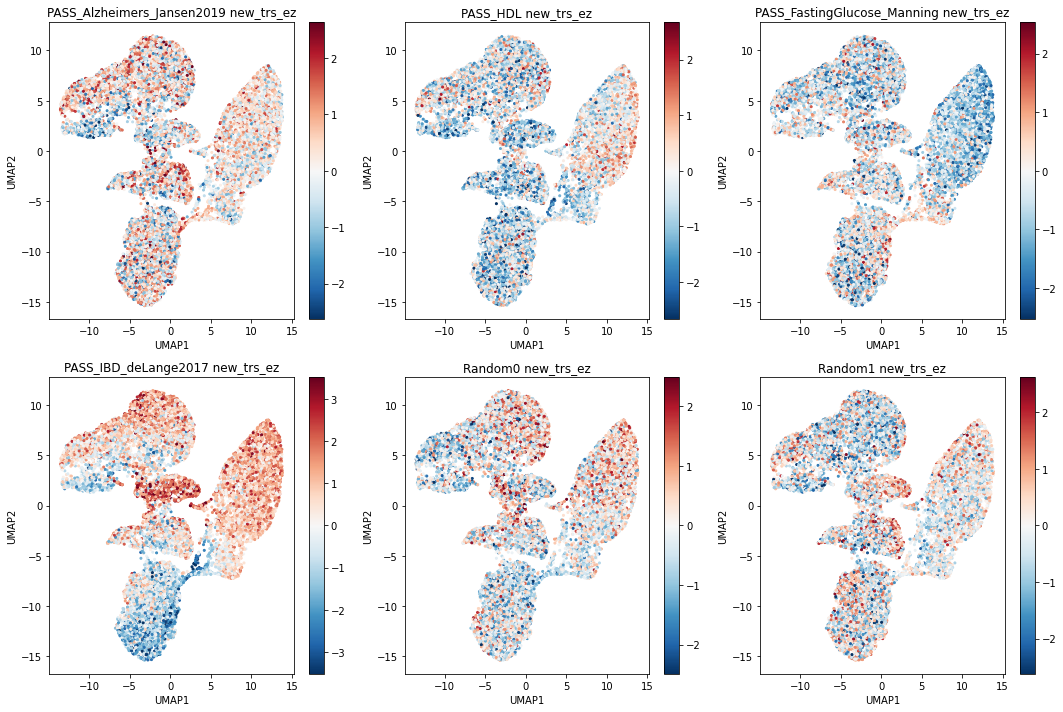

In [41]:
plot_list = [['Liver', 'trs_ez', TRAIT_LIST],
             ['Liver', 'new_trs_ez', TRAIT_LIST],
             ['BAT', 'trs_ez', TRAIT_LIST],
             ['BAT', 'new_trs_ez', TRAIT_LIST],
             ['Marrow', 'trs_ez', TRAIT_LIST],
             ['Marrow', 'new_trs_ez', TRAIT_LIST]]

for tissue,config,trait_plot_list in plot_list:
    
    adata_small = dic_data_facs[tissue].copy()    
    df_plot = pd.DataFrame(index=adata_small.obs.index)
    df_plot['UMAP1'] = adata_small.obsm['X_umap'][:,0]
    df_plot['UMAP2'] = adata_small.obsm['X_umap'][:,1]
    
    # Trait TRS plot
    print(tissue,config)
    plt.figure(figsize=[15,10])
    for i_trait,trait in enumerate(trait_plot_list):
        
        plt.subplot(2,3,i_trait+1)
        temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
        temp_df[trait] = dic_trs['%s;%s'%(trait, config)]
        df_plot = df_plot.join(temp_df[trait])
            
        
        max_ = np.quantile(np.absolute(df_plot[trait].values), 0.99)
        min_ = np.quantile(np.absolute(df_plot[trait].values), 0.01)
        plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[trait],
                    cmap='RdBu_r', vmax=max_, vmin=-max_, s=4)
        plt.colorbar()
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('%s %s'%(trait, config))
        
    plt.tight_layout()
    plt.show()